<h2>Setup</h2>
<p>In this we will setup the necessary libraries whicih we will use in our project</p>

In [1]:
!pip install nlp


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.0


In [3]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

<h2> Import the data</h2>
<p>In here we are using the nlp libray of hugging face so we are importing the available dataset from there.</p>

In [4]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


In [5]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [6]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [7]:
tweets, labels = get_tweets(train)

tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

<h2>Tokenizing the tweets</h2>
<p>In this part we will give some unique tokens to each words used int the tweets</p>


In [8]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token='<OOV>')

tokenizer.fit_on_texts(tweets)

print(tweets[4])
print(tokenizer.texts_to_sequences([tweets[4]]))

i am feeling grouchy
[[2, 24, 8, 1065]]


<h2>Padding and Truncating Sequences</h2>
<p>In this part we will find the best size for the array and padd everything to that length</p>



<h4>1. Checking the tweet lengths</h4>

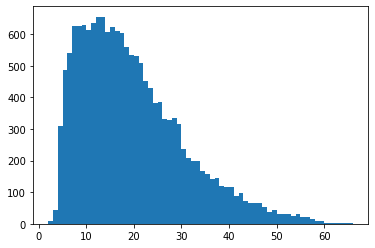

In [9]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

<h4>2. Creating padded sequences</h4>

In [10]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [11]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [12]:
print(tweets[0])
padded_train_sequences[0]

i didnt feel humiliated


array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

<h2>Preparing the Labels</h2>
<p>In this part we will set unique indexes for the labels </p>


<h4>Creating classes to index and index to classes dictionaries</h4>

In [13]:
classes = set(labels)
print(classes)

{'love', 'anger', 'sadness', 'joy', 'fear', 'surprise'}


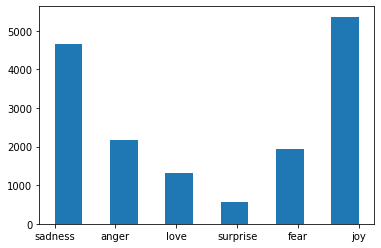

In [14]:
plt.hist(labels, bins=11)
plt.show()

In [15]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [16]:
classes_to_index

{'love': 0, 'anger': 1, 'sadness': 2, 'joy': 3, 'fear': 4, 'surprise': 5}

In [17]:
index_to_classes

{0: 'love', 1: 'anger', 2: 'sadness', 3: 'joy', 4: 'fear', 5: 'surprise'}

<h4>Converting text labels to numeric labels</h4>

In [18]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [19]:
train_labels = names_to_ids(labels)
print(train_labels[0])

2


<h2>Creating and Compiling the model</h2>
<p>In this part of the code we will set up and compile the model</p>

In [20]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


<h2>Training the Model</h2>
<p>In this part we will prepare the validation set initially and then train the model and test for accuracy</p>

<h4>1. Preparing the validation set</h4>

In [21]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [22]:
val_tweets[0], val_labels[0]


('im feeling quite sad and sorry for myself but ill snap out of it soon', 2)

In [57]:
padded_train_sequences

array([[   2,  139,    3, ...,    0,    0,    0],
       [   2,   40,  101, ...,    0,    0,    0],
       [  17, 3060,    7, ...,    0,    0,    0],
       ...,
       [   2,    3,  327, ...,    0,    0,    0],
       [   2,    3,   14, ...,    0,    0,    0],
       [   2,   47,    7, ...,    0,    0,    0]])

<h4>2. Training the model</h4>

In [23]:
history = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/50
500/500 [==============================] - 24s 27ms/step - loss: 1.3261 - accuracy: 0.4519 - val_loss: 0.8154 - val_accuracy: 0.6895
Epoch 2/50
500/500 [==============================] - 17s 35ms/step - loss: 0.5989 - accuracy: 0.7822 - val_loss: 0.5989 - val_accuracy: 0.8015
Epoch 3/50
500/500 [==============================] - 22s 43ms/step - loss: 0.3377 - accuracy: 0.8885 - val_loss: 0.4740 - val_accuracy: 0.8445
Epoch 4/50
500/500 [==============================] - 25s 50ms/step - loss: 0.2158 - accuracy: 0.9294 - val_loss: 0.4608 - val_accuracy: 0.8660
Epoch 5/50
500/500 [==============================] - 22s 44ms/step - loss: 0.1413 - accuracy: 0.9553 - val_loss: 0.3798 - val_accuracy: 0.8900
Epoch 6/50
500/500 [==============================] - 24s 49ms/step - loss: 0.1069 - accuracy: 0.9675 - val_loss: 0.3887 - val_accuracy: 0.8905
Epoch 7/50
500/500 [==============================] - 23s 45ms/step - loss: 0.0874 - accuracy: 0.9738 - val_loss: 0.4106 - val_accuracy:

<h2>Evlauating the model</h2>

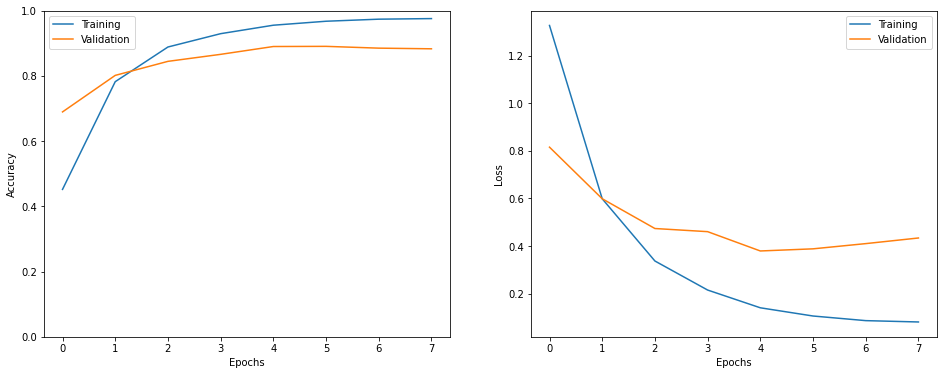

In [24]:
show_history(history)

In [25]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [26]:
_ = model.evaluate(test_sequences, test_labels)


63/63 [==============================] - 1s 19ms/step - loss: 0.4401 - accuracy: 0.8700


<h4>Just testing the output for random samples</h4>

In [27]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_classes[test_labels[i]])

p = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]
pred_class = index_to_classes[np.argmax(p).astype('int')]
print('Predicted Emotion:', pred_class)

Sentence: i grab it from the air its smooth frame feels cold to the touch
Emotion: anger
Predicted Emotion: anger


In [28]:
y_predict = np.argmax(model.predict(test_sequences),axis=1)

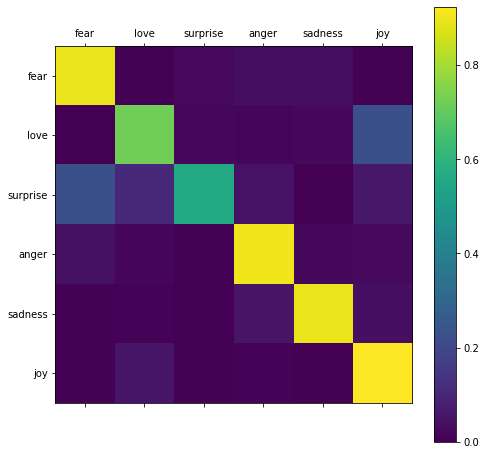

In [38]:
show_confusion_matrix(test_labels, y_predict, list(classes))

In [29]:
tf.keras.models.save_model(model, "./model.h5")

In [31]:
model = tf.keras.models.load_model("./model.h5")

In [61]:
# Define the function to predict the sentiment of a text
def predict_sentiment(text):
    # Preprocess the input text
    token = tokenizer.texts_to_sequences([text])
    print(token)
    paded = tf.keras.preprocessing.sequence.pad_sequences([token[0]], maxlen=50, padding="post")
    print(paded)
    #padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    
    # Predict the sentiment
    p = model.predict(paded)
    sentiment = index_to_classes[np.argmax(p).astype('int')]
    
    # Return the sentiment
    return sentiment

In [65]:
# Example usage
text = "This is."
sentiment = predict_sentiment(text)
print("Sentiment:", sentiment)

[[23, 22]]
[[23 22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]]
Sentiment: sadness


In [52]:
text = "i am happy"
print(tokenizer.texts_to_sequences([text]))

[[2, 24, 154]]


In [58]:
test_sequences[2]

array([   2,  145,   80,   68, 2971,   60,   18,   37,    2,  104,   43,
        165,   67,   68,    5,    3,   14,    2,   93,  406,   25,   68,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

In [67]:
import pickle

# Save the model as a pickle file
with open("./model.pkl", "wb") as file:
    pickle.dump(model, file)

INFO:tensorflow:Assets written to: ram://43ea0b11-be3f-4aa8-a513-6974ca1c47a5/assets


INFO:tensorflow:Assets written to: ram://43ea0b11-be3f-4aa8-a513-6974ca1c47a5/assets


In [68]:
# Save the model as a pickle file
with open("./tokenizer.pkl", "wb") as file:
    pickle.dump(tokenizer, file)

In [69]:
# Save the model as a pickle file
with open("./index_to_class.pkl", "wb") as file:
    pickle.dump(index_to_classes, file)